Mestrado em Modelagem Matematica da Informacao
----------------------------------------------
Disciplina: Modelagem e Mineracao de Dados
------------------------------------------

Master Program - Mathematical Modeling of Information
-----------------------------------------------------
Course: Data Mining and Modeling
--------------------------------

Professor: Renato Rocha Souza
-----------------------------

### Topic: Geographical and Spatial Analysis

In [1]:
from __future__ import division
import twitter
import nltk
import re
import networkx as nx
import sys
import os
import json
import time
from itertools import chain
import urllib
from datetime import datetime
from datetime import timedelta
import webbrowser
import codecs
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopy.geocoders as gg
from nominatim import Nominatim
import Levenshtein
from bs4 import BeautifulSoup
from IPython.display import Image, HTML, IFrame, FileLink, FileLinks #needed to render in notebook
from IPython.core.display import display
#import pydot  #Install http://www.graphviz.org/ & https://pypi.python.org/pypi/pydot2/1.0.32 pydot --> pip install pydot2

%matplotlib inline
# Set default figure size for this notebook
plt.rcParams['figure.figsize'] = (16.0, 12.8)

/home/rsouza/python/3/venv/local/lib/python3.5/site-packages/nltk/decorators.py:59: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  regargs, varargs, varkwargs, defaults = inspect.getargspec(func)


#### Specifying the path to the files

In [2]:
templates = "../templates/"
outputs = "../outputs/"

dotfile = "graph_retweet.dot"
pngfile = "graph_retweet.png"
protofile = "graph_retweet.html"
tweetsfile = "Tweets_dump.txt"
template_proto = 'template_protoviz.html'

pathdotfile = os.path.join(outputs,dotfile)
pathpngfile = os.path.join(outputs,pngfile)
pathprotofile = os.path.join(outputs,protofile)
pathtweetsfile = os.path.join(outputs,tweetsfile)
pathtemplate = os.path.join(templates,template_proto)

stoplist_en = nltk.corpus.stopwords.words('english')
stoplist_pt = nltk.corpus.stopwords.words('portuguese')
ignorewords = stoplist_en + stoplist_pt + ['',' ','-','rt']

### Using geographical resources within Python

In [3]:
#https://pypi.python.org/pypi/geopy  

gg.OpenMapQuest()
geolocator = gg.GoogleV3()

To geolocate a query to an address and coordinates:

In [4]:
logradouro = "Dona Mariana, Botafoga" #Note that there is a typo in the name "Botafogo"
address, (latitude, longitude) = geolocator.geocode(logradouro)
print(address)
print(latitude, longitude)

Rua Dona Mariana - Botafogo, Rio de Janeiro - RJ, Brazil
-22.9529422 -43.1886221


In [5]:
#Measuring editing distances between names:
Levenshtein.ratio('Dona Mariana, Botafoga', 'Rua Dona Mariana - Botafogo')

0.8163265306122449

In [6]:
#https://developers.google.com/maps/documentation/staticmaps/
#http://stackoverflow.com/questions/2660201/what-parameters-should-i-use-in-a-google-maps-url-to-go-to-a-lat-lon/9919251#9919251
#m – normal map k – satellite h – hybrid p – terrain

def gmap(address,lat,lon,zoom=15,tmap='m'):
    # Google Maps URL template for an iframe
    google_maps_url = 'http://maps.google.com/maps?q={0}&loc:{1}+{2}&z={3}&t={4}&output=embed'.format(address,
                                                                                                     lat,
                                                                                                     lon,
                                                                                                     zoom,
                                                                                                     tmap,)
    display(IFrame(google_maps_url, '800px', '600px'))
    
gmap(address, latitude, longitude,17,'k')

To find the address corresponding to a set of coordinates:

In [7]:
addresses = geolocator.reverse("46.649,6.383")
for address in addresses:
    print(address)

Fauchy, 1148 Mont-la-Ville, Switzerland
1148 Mont-la-Ville, Switzerland
1148 Moiry, Switzerland
Morges District, Switzerland
Vaud, Switzerland
Switzerland


### Using Python and QGIS for geospatial visualizations - a Case Study  
https://www.airpair.com/python/posts/using-python-and-qgis-for-geospatial-visualization  

In [8]:
base_url = "http://www.nuforc.org/webreports/"
index_url = "http://www.nuforc.org/webreports/ndxevent.html"

In [9]:
def can_cast_as_dt(dateStr, fmt):
    try:
        datetime.strptime(dateStr, fmt)
        return True
    except ValueError:
        return False

def parse_dt(dateStr):
    # the data in the website comes in two different formats, try both 
    for fmt in ["%m/%d/%y %H:%M", "%m/%d/%y"]:
        try:
            return datetime.strptime(dateStr, fmt)
        except ValueError:
            continue

def get_data_from_url(url):
    print("Processing {}".format(url))
    data = []
    source = BeautifulSoup(urllib.request.urlopen(url), "html5lib")
    for row in source('tr'):
        if not row('td'):
            continue # header row
        row_data = row('td')
        # parse the datetime from the string
        date_time = parse_dt(row_data[0].text)
        city = row_data[1].text
        state = row_data[2].text
        shape = row_data[3].text
        duration = row_data[4].text
        data.append((date_time, city, state, shape, duration))
    return data

In [10]:
# get the index page
raw_page = urllib.request.urlopen(index_url)
source = BeautifulSoup(raw_page, "html5lib")
# get all the links in the index page
func1 = lambda x: (x.text, base_url + x['href'])
monthly_urls = list(map(func1,source('a')))
# get  the last 12 links that have a text like 06/2015
func2 = lambda x: can_cast_as_dt(x[0], "%m/%Y")
last_year_urls = filter(func2, monthly_urls[0:13]) 
# extract the data from each monthly page and flatten the lists of tuples
last_year_ufos = list(chain(*map(lambda x: get_data_from_url(x[1]), last_year_urls)))
# initialize a pandas DataFrame with the list of tuples

Processing http://www.nuforc.org/webreports/ndxe201609.html
Processing http://www.nuforc.org/webreports/ndxe201608.html
Processing http://www.nuforc.org/webreports/ndxe201607.html
Processing http://www.nuforc.org/webreports/ndxe201606.html
Processing http://www.nuforc.org/webreports/ndxe201605.html
Processing http://www.nuforc.org/webreports/ndxe201604.html
Processing http://www.nuforc.org/webreports/ndxe201603.html
Processing http://www.nuforc.org/webreports/ndxe201602.html
Processing http://www.nuforc.org/webreports/ndxe201601.html
Processing http://www.nuforc.org/webreports/ndxe201512.html
Processing http://www.nuforc.org/webreports/ndxe201511.html
Processing http://www.nuforc.org/webreports/ndxe201510.html


In [11]:
ufos_df = pd.DataFrame(last_year_ufos, columns=["start","city","state","shape","duration_description"])

In [12]:
ufos_df.head()

,start,city,state,shape,duration_description
0,2016-09-02 00:00:00,Greenfield,WI,Fireball,5 minutes
1,2016-09-01 22:30:00,Brookfield,WI,Other,15 minutes
2,2016-09-01 22:00:00,Lehighton,PA,Fireball,5 minutes
3,2016-09-01 10:00:00,Dollar Bay,MI,Formation,2+ hours
4,2016-09-01 05:29:00,Vale,NC,Light,2 seconds


In [13]:
ufos_df.replace(to_replace='', value=np.nan, inplace=True, limit=None, regex=False, method='pad', axis=None)
ufos_df = ufos_df.dropna() 

In [14]:
ufos_df.head()

,start,city,state,shape,duration_description
0,2016-09-02 00:00:00,Greenfield,WI,Fireball,5 minutes
1,2016-09-01 22:30:00,Brookfield,WI,Other,15 minutes
2,2016-09-01 22:00:00,Lehighton,PA,Fireball,5 minutes
3,2016-09-01 10:00:00,Dollar Bay,MI,Formation,2+ hours
4,2016-09-01 05:29:00,Vale,NC,Light,2 seconds


#### Engineering time

In [15]:
# function that infers the duration from the text 
def infer_duration_in_seconds(text):
    # try different regexps to extract the total seconds
    text = text.replace('<','')
    text = text.replace('>','')
    text = text.replace('?','')
    text = text.replace('+','')
    text = text.replace('~','')
    metric_text = ["second","s","Second","segundo","minute","m","min","Minute","hour","h","Hour",'Currently']
    metric_seconds = [1,1,1,1,60,60,60,3600,3600,3600,10]
    for metric,mult in zip(metric_text, metric_seconds):
        regex = "\s*(\d+)\+?\s*{}s?".format(metric)
        res = re.findall(regex,text)
        if len(res)>0:
            return int(float(res[0]) * mult)
    return 0

In [16]:
# extract the duration in seconds
ufos_df["duration_secs"] = ufos_df["duration_description"].apply(infer_duration_in_seconds)

# now we can infer the end time of the UFO sighting as well
# which will be useful for the animation later
ufos_df["end"] = ufos_df.apply(lambda x:x["start"] + timedelta(seconds=x["duration_secs"]),axis=1)
ufos_df = ufos_df.dropna()

In [17]:
ufos_df.head()

,start,city,state,shape,duration_description,duration_secs,end
0,2016-09-02 00:00:00,Greenfield,WI,Fireball,5 minutes,300,2016-09-02 00:05:00
1,2016-09-01 22:30:00,Brookfield,WI,Other,15 minutes,900,2016-09-01 22:45:00
2,2016-09-01 22:00:00,Lehighton,PA,Fireball,5 minutes,300,2016-09-01 22:05:00
3,2016-09-01 10:00:00,Dollar Bay,MI,Formation,2+ hours,7200,2016-09-01 12:00:00
4,2016-09-01 05:29:00,Vale,NC,Light,2 seconds,2,2016-09-01 05:29:02


#### Finding Locations

In [18]:
# http://wiki.openstreetmap.org/wiki/Nominatim_usage_policy
# https://github.com/twain47/Nominatim/blob/master/docs/Installation.md
geolocator = Nominatim()

geolocator.query('Newport News')
#geolocator.query("Houston, TX")

[{'boundingbox': ['36.930691', '37.2206658', '-76.6460929', '-76.3616099'],
  'class': 'place',
  'display_name': 'Newport News, Newport News City, Virginia, United States of America',
  'icon': 'http://nominatim.openstreetmap.org/images/mapicons/poi_place_city.p.20.png',
  'importance': 0.70997691224355,
  'lat': '37.016827',
  'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://www.openstreetmap.org/copyright',
  'lon': '-76.4505195',
  'osm_id': '206655',
  'osm_type': 'relation',
  'place_id': '144553196',
  'type': 'city'},
 {'boundingbox': ['37.0728977', '37.0731352', '-76.478543', '-76.478097'],
  'class': 'amenity',
  'display_name': 'Station 8, Kingstowne Drive, Deer Park, Newport News, Newport News City, Virginia, 23606, United States of America',
  'icon': 'http://nominatim.openstreetmap.org/images/mapicons/amenity_firestation3.p.20.png',
  'importance': 0.201,
  'lat': '37.0730099',
  'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://www.openstreet

In [21]:
#Be careful with too many queries made to the server in a short period of time

ufos_df["lat"] = 0
ufos_df["lon"] = 0
for i in range(len(ufos_df[0:10])):
    resp_json = geolocator.query(ufos_df['city'][i])
    try:
        ufos_df["lat"][i] = resp_json[0]['lat']
        ufos_df["lon"][i] = resp_json[0]['lon']
    except:
        ufos_df["lat"][i] = 0
        ufos_df["lat"][i] = 0
    time.sleep(1.5)

/home/rsouza/python/3/venv/local/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/rsouza/python/3/venv/local/lib/python3.5/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/home/rsouza/python/3/venv/local/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [22]:
# http://stackoverflow.com/questions/17098654/how-to-store-data-frame-using-pandas-python
ufos_df.to_pickle(os.path.join(outputs,'ufos_df.pkl'))
ufos_df = pd.read_pickle(os.path.join(outputs,'ufos_df.pkl'))
ufos_df.head()

,start,city,state,shape,duration_description,duration_secs,end,lat,lon
0,2016-09-02 00:00:00,Greenfield,WI,Fireball,5 minutes,300,2016-09-02 00:05:00,42.5877962,-72.6006198
1,2016-09-01 22:30:00,Brookfield,WI,Other,15 minutes,900,2016-09-01 22:45:00,43.0605671,-88.1064786
2,2016-09-01 22:00:00,Lehighton,PA,Fireball,5 minutes,300,2016-09-01 22:05:00,40.8337029,-75.7138007
3,2016-09-01 10:00:00,Dollar Bay,MI,Formation,2+ hours,7200,2016-09-01 12:00:00,47.1196494,-88.5115108
4,2016-09-01 05:29:00,Vale,NC,Light,2 seconds,2,2016-09-01 05:29:02,13.2904027,108.4265113


In [23]:
# Note: dropna will drop any columns with None values, which is desirable
ufos_df[["start","end","lon","lat","shape"]].dropna().to_csv(os.path.join(outputs,'ufo_data.csv'),
                                                             index=False, 
                                                             encoding="utf-8")

### Using geographical resources for twitter Analysis

https://github.com/bear/python-twitter (before was http://code.google.com/p/python-twitter/)  
https://dev.twitter.com/docs  

Twitter API Keys  
Please generate yours...  
Go to http://twitter.com/apps/new to create an app and get these items  
See https://dev.twitter.com/docs/auth/oauth for more information on Twitter's OAuth implementation  
https://dev.twitter.com/rest/reference/get/account/verify_credentials  
https://dev.twitter.com/docs/auth/oauth  
https://dev.twitter.com/apps/new  

Inspiration: http://onemilliontweetmap.com/  

In [24]:
with open('twitter_tokens.txt', 'r') as twitter_tokens:
    tokens = twitter_tokens.read().split(',')
consumer_key = tokens[0].strip()
consumer_secret = tokens[1].strip()
access_token = tokens[2].strip()
access_token_secret = tokens[3].strip()

Acessing Twitter (with or without authentication)

In [25]:
#api = twitter.Api() # Accessing with no authentication
api = twitter.Api(consumer_key, consumer_secret, access_token, access_token_secret)

In [26]:
print(api.VerifyCredentials())

{"created_at": "Thu Apr 09 10:44:07 +0000 2009", "description": "Researcher and Professor", "favourites_count": 1, "followers_count": 494, "friends_count": 133, "id": 29959702, "lang": "en", "listed_count": 19, "location": "Rio de Janeiro", "name": "Renato Rocha Souza", "profile_background_color": "9AE4E8", "profile_background_image_url": "http://pbs.twimg.com/profile_background_images/33941499/8.jpg", "profile_image_url": "http://pbs.twimg.com/profile_images/503088023/Renato2_normal.JPG", "profile_link_color": "0084B4", "profile_sidebar_fill_color": "DDFFCC", "profile_text_color": "333333", "screen_name": "rrsouza", "status": {"created_at": "Mon Jan 05 11:05:11 +0000 2015", "hashtags": [{"text": "FGV"}, {"text": "emap"}], "id": 552058220781797376, "id_str": "552058220781797376", "lang": "und", "source": "<a href=\"http://twitter.com\" rel=\"nofollow\">Twitter Web Client</a>", "text": "http://t.co/5l4lGVKiBG #FGV #emap", "urls": [{"expanded_url": "http://blog.udacity.com/2014/11/data-s

#### Lexical Analysis

Recent (random) public messages

In [27]:
msgpublicas = api.GetStreamSample()

In [28]:
for i in range(15):
    tweet = next(msgpublicas)
    if 'text' in tweet:
        print(u'{}\n'.format(tweet['text']))

#DolceAmoreParangalPaulinian  You can't dance to the beat of a heart that's broken / #PushAwardsLizQuens

#DolceAmoreParangalPaulinian  You can't dance to the beat of a heart that's broken / #PushAwardsLizQuens

#DolceAmoreParangalPaulinian  You can't dance to the beat of a heart that's broken / #PushAwardsLizQuens

#DolceAmoreParangalPaulinian  You can't dance to the beat of a heart that's broken / #PushAwardsLizQuens

@___back________ 
自分でも、己自身の面倒なこういう気持ちを、うまく制御できたらいいんだが……なかなかうまくいかない……
（俯き口を尖らせて）

んんんっ、ん！！褒められた！！
（きらきらと瞳を輝かせては抱き着いて首を傾げ）
ふふ、君なら、せくはらして良いぞー？

あれ決めないってなんなん？

#DolceAmoreParangalPaulinian  You can't dance to the beat of a heart that's broken / #PushAwardsLizQuens

#DolceAmoreParangalPaulinian  You can't dance to the beat of a heart that's broken / #PushAwardsLizQuens

元気はレッズの時かなり守備してくれてたしボランチやらせれてるのは代表の時だけじゃん

@nimikyan 
......マジかwww

嘘だよwww

#DolceAmoreParangalPaulinian  You can't dance to the beat of a heart that's broken / #PushAwardsLizQuens

#DolceAmoreParangalPaulini

Tweet Structure

In [29]:
while True:
    tweet = next(msgpublicas)
    if 'user' in tweet:
        break
tweet

{'contributors': None,
 'coordinates': None,
 'created_at': 'Tue Sep 06 12:32:06 +0000 2016',
 'entities': {'hashtags': [],
  'symbols': [],
  'urls': [{'display_url': 'fb.me/LXz2Bryb',
    'expanded_url': 'http://fb.me/LXz2Bryb',
    'indices': [0, 23],
    'url': 'https://t.co/hZIN8QQXPs'}],
  'user_mentions': []},
 'favorite_count': 0,
 'favorited': False,
 'filter_level': 'low',
 'geo': None,
 'id': 773136693876580352,
 'id_str': '773136693876580352',
 'in_reply_to_screen_name': None,
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'is_quote_status': False,
 'lang': 'und',
 'place': None,
 'possibly_sensitive': False,
 'retweet_count': 0,
 'retweeted': False,
 'source': '<a href="http://www.facebook.com/twitter" rel="nofollow">Facebook</a>',
 'text': 'https://t.co/hZIN8QQXPs',
 'timestamp_ms': '1473165126662',
 'truncated': False,
 'user': {'contributors_enabled': False,
  'created_at': 'Wed Nov 28

In [30]:
Image(url='http://mike.teczno.com/img/raffi-krikorian-map-of-a-tweet.png')

Recent messages from an user

In [31]:
msguser = api.GetUserTimeline(tweet['user']['id'])
print([s.text for s in msguser])

['https://t.co/hZIN8QQXPs', 'Eu publiquei uma nova foto no Facebook https://t.co/6eGd1kLOFc', 'Eu publiquei uma nova foto no Facebook https://t.co/yTCsZHSfgl', 'Eu publiquei uma nova foto no Facebook https://t.co/GkjRTzAZD3', 'Eu publiquei uma nova foto no Facebook https://t.co/QIrmCRnkW3', 'Eu publiquei uma nova foto no Facebook https://t.co/5EySgT5wtU', 'Eu publiquei uma nova foto no Facebook https://t.co/Ad9yC3RjCu', 'Eu publiquei uma nova foto no Facebook https://t.co/0bBPvVmGId', 'Eu publiquei uma nova foto no Facebook https://t.co/ACMdbjbHjS', 'Eu publiquei uma nova foto no Facebook https://t.co/4TJ5Um5W20', 'Eu publiquei uma nova foto no Facebook https://t.co/jKsjEia8Kb', 'Eu publiquei uma nova foto no Facebook https://t.co/GToRHTZBd7', 'Eu publiquei uma nova foto no Facebook https://t.co/sQzq4N9GpD', 'Eu publiquei uma nova foto no Facebook https://t.co/qvAetPs8uw', 'Eu publiquei uma nova foto no Facebook https://t.co/cIdHUDPy9I', 'Eu publiquei uma nova foto no Facebook https://

Recent messages from the authenticated user

In [32]:
msguser = api.GetUserTimeline('rrsouza')
#msguser = api.GetUserTimeline('29959702')
print([s.text for s in msguser])

['http://t.co/5l4lGVKiBG #FGV #emap', 'Olá Pessoal! Fiquem atentos à aula de Modelagem e Mineração de Dados... Hoje análises com Twitter!', 'Mais um curioso fenômeno dos nossos tempos: #LeakForJLaw Or maybe #LeakForPerverts ?', 'RT @mashable: 8 Brutally Honest Facebook Notifications That Need to Exist Now http://t.co/wwFQ1hut9x http://t.co/b2GjxcNb6D', '#Cite10CoisasQueSuaMãeFala come alguma coisa antes para não chegar na festa esfomeado', 'Implicações do Big Data para as questões de privacidade: http://t.co/WDJwxpOr9d', 'Resultados da seleção do Mestrado em Modelagem Matemática da Informação - turma 2013 saem nesta sexta, 08/02. #FGV #EMAp', 'RT @PyPLN: We just released the very first version (0.1.0) of pypln.api -- a Python library to programatically access @PyPLN Web! http:/ ...', "Men's Fitness UK by Dennis Publishing Ltd http://t.co/y8YZBBeP", "I'm at Capes (Brasília, DF) w/ 2 others http://t.co/QiukVJqW", "I'm at Capes (Brasília, DF) http://t.co/OfRoPS0y", '@israelst na verdade, 

After authentication, more options are available

In [33]:
userfollow = api.GetFriends()
print([u.name for u in userfollow])

['Lucas Parisi', 'Carla Codeço Coelho', 'Overleaf', 'Cláudio Berrondo', 'Flávio Amieiro', 'Pablo Cerdeira', 'Cut the Rope', 'Machinalis', 'MiningTheSocialWeb', 'CNET News', 'ReadWrite', 'The Next Web 🌍💻📱', 'CNET', 'The Verge', 'Engadget', 'Lifehacker', 'Gizmodo', 'WIRED', 'TechCrunch', 'Ian Ozsvald', 'CNPq', 'Claudio Gnoli', 'strongsteam', 'Diana Maynard', 'Joyce Figueiró', 'Álvaro Justen', 'PyPLN', 'Open Source For You', 'TechRepublic', 'ZDNet', 'Twitter API', 'Udacity', 'Clarissa', 'Roberto R.S.Sobrinho', 'Luana Sales', 'Sensacionalista', 'André Branco', 'CMA', 'Asla Sá', 'Renata Teixeira', 'FGV EMAp', 'FGV', 'FGV Marketing', 'CPDOC', 'Globant Brasil', 'Sheffield NLP', 'Débora Pereira', 'André Andrade', "O'Reilly Radar", 'Virgilio Almeida', 'Dalai Lama', 'Alexandre Colucci', 'Benildes Maculan', 'Gabriel Rezende', 'Mashable', 'alfredo hirsch', 'Fernando S Parreiras', 'NYTimes Bits', 'MiniCursos', 'Googleverse', 'Hootsuite', 'G1 - Concursos', 'Ivana', 'Dina Araujo', 'João Batista', 'W3

Searching for a term in tweets

In [50]:
def search_for_term(termo, pages, results):
    '''Search and return tweets on a subject (5 pages of 100 results each)
    Save results in a file defined in "pathtweetsfile" '''
    search_results = []
    tweets = []
    tweets_txt = []
    tweets_words = []
    names = []
    last = api.GetSearch(term=termo, count=1)
    search_results.append(last)
    list_ids = []
    list_ids.append(last[0].id)
    for i in range(pages):
        id_last = last[0].id
        new_tweets = api.GetSearch(term=termo, count=results, max_id=min(list_ids))
        for i in range(len(new_tweets)):
            list_ids.append(new_tweets[i].id)
        search_results.append(new_tweets)
    for i in range(len(search_results)):
        for j in range(len(search_results[i])):
            tweets.append(search_results[i][j])
    tweets_txt += [tweet.text.split(u' ') for tweet in tweets]
    for i in range(len(tweets)):
        tweets_words += [word.lower().strip(u':@&$!?') for word in tweets_txt[i]]
    for i in range(len(tweets)): 
        names += [word.strip(u':@&$!?') for word in tweets_txt[i] if word.istitle() and len(word) > 2]
    with open(pathtweetsfile,'w') as out:
        for tweet in tweets_txt:
            out.write(u'\n{}'.format(tweet))
    return tweets, tweets_txt, tweets_words, names

def lexical_diversity(text):
    return len(text) / len(set(text))

In [72]:
twitter_query = u'olympics'

search = api.GetSearch(twitter_query)
print([s.text for s in search])

["Can you believe it's been a month since the Opening Ceremony? Wasn't it gorgeous?! ❤️ We miss #Rio2016! 😢 https://t.co/ouzpFVyTNZ", '44 years ago today, Palestinian terrorists killed 11 Israeli athletes during the Munich Olympics. #InMemory https://t.co/oiZ1XapFod', 'On this day in 1960, Muhammad Ali (then Cassius Clay) won gold for Team USA at the Rome Olympics 💪🏼🏅🙌🏼 https://t.co/8oH5rm8WLI', "RT @TheFactsOfShade: 'Rise' a promotional song for the Olympics has received 20 more million views than 'Make Me' which is a lead single. h…", "RT @SteveStiffIer: Oh you're a fan of the Olympics? Then who is this? https://t.co/F2R2U3wKqF", 'RT @TennisChannel: Medal from @Olympics, a #USOpen to remember, yet all humility from @DelPotroJuan. Watch. --&gt; https://t.co/VFZSKIwFZO htt…', 'RT @Hashtag_DonJon: Pang Olympics yung cheer mo ah! 👍🏼 https://t.co/8VKMkOnvSf', 'RT @BSO: Usain Bolt Gets Engaged After GF Gives Him 27 Girls Sex Olympics Hall Pass (Vid) https://t.co/nUCkiryr6k https://t.co/PMM

Using our customized function that retrieves 5 x 100 tweets

In [73]:
tweets, tweets_txt, tweets_words, names = search_for_term(twitter_query,5,10)
    
print('Word count: {}'.format(len(tweets_words)))
print('Repertoire: {}'.format(len(set(tweets_words))))
print('Lexical diversity: {}'.format(lexical_diversity(tweets_words)))

Word count: 793
Repertoire: 315
Lexical diversity: 2.5174603174603174


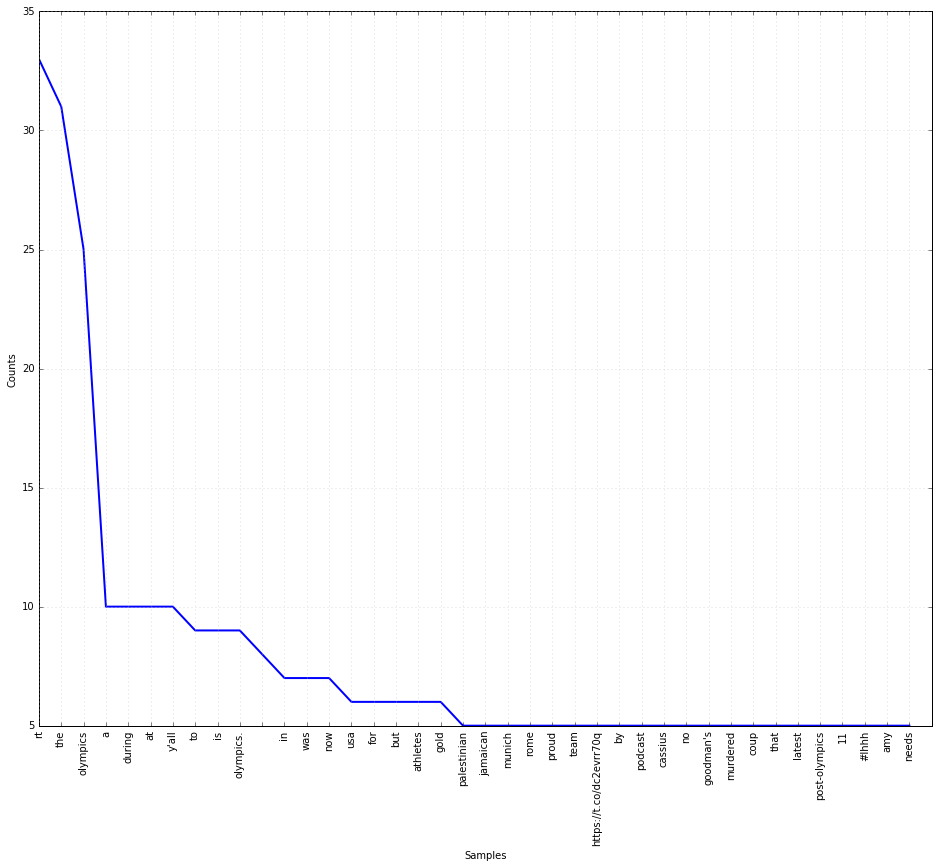

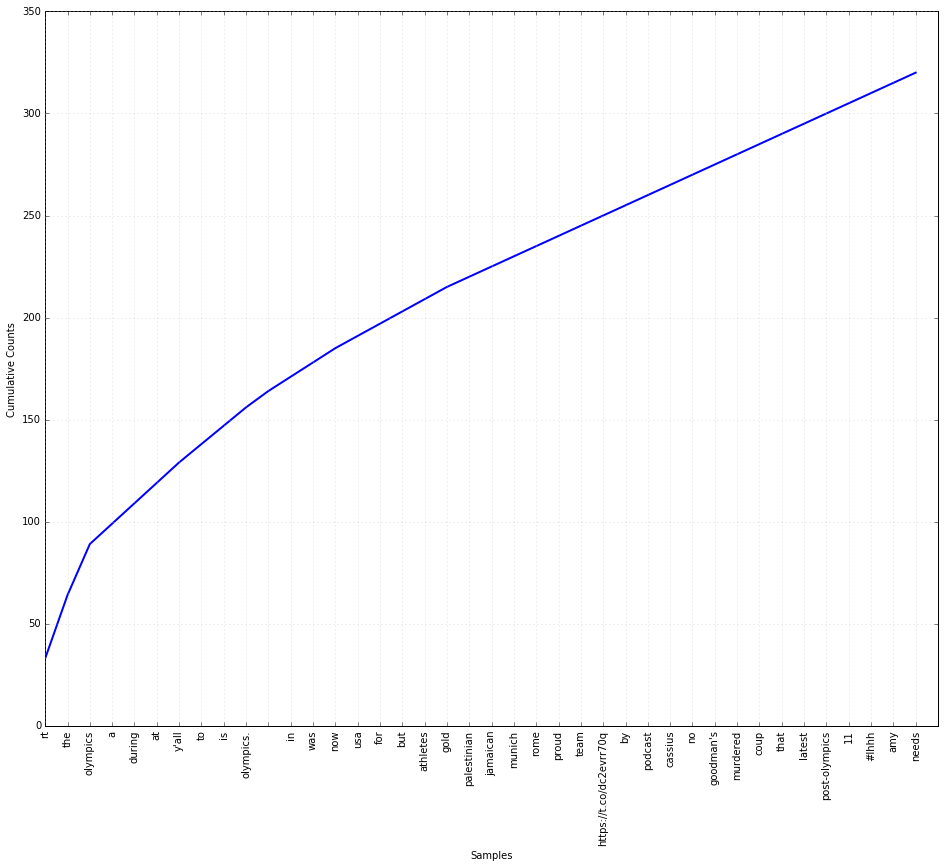

In [74]:
freq_dist = nltk.FreqDist(tweets_words)
freq_dist.plot(40)
freq_dist.plot(40, cumulative = True)

In [75]:
#print('10 most frequent words')
print(freq_dist.most_common())

[('rt', 33), ('the', 31), ('olympics', 25), ('a', 10), ('during', 10), ('at', 10), ("y'all", 10), ('to', 9), ('is', 9), ('olympics.', 9), ('', 8), ('in', 7), ('was', 7), ('now', 7), ('usa', 6), ('for', 6), ('but', 6), ('athletes', 6), ('gold', 6), ('palestinian', 5), ('jamaican', 5), ('munich', 5), ('rome', 5), ('proud', 5), ('team', 5), ('https://t.co/dc2evrr70q', 5), ('by', 5), ('podcast', 5), ('cassius', 5), ('no', 5), ("goodman's", 5), ('murdered', 5), ('coup', 5), ('that', 5), ('latest', 5), ('post-olympics', 5), ('11', 5), ('#lhhh', 5), ('amy', 5), ('needs', 5), ('game"', 5), ('be', 5), ('terrorists', 5), ('"in', 5), ('we', 5), ('won', 5), ('israeli', 5), ('wya', 5), ('democracynow', 5), ('political', 5), ('safaree', 5), ('brazil,', 5), ('ali', 4), ('muhammad', 4), ('after', 4), ('#onthisday', 4), ('clay)', 4), ('(then', 4), ('2016', 4), ('1972', 4), ('this', 4), ('rio', 4), ('https://t.co/6dxlaubbt3', 4), ('#olympics', 4), ('yb__qb', 4), ('on', 4), ('https://t.co/pmmpgxn9js', 3)

In [76]:
print('Sorted list of words')
print(sorted(set(tweets_words)))

Sorted list of words
['', '"in', '#boston', '#boxing', '#cdnparalympic', '#competition', '#filltheseats', '#girlpower', '#inmemory', '#israeli', '#lhhh', '#msgwishes', '#munich', '#neverforget', '#olympics', '#onthisday', '#rio2016', "'losing'", "'nejdeh'", '(cbc):#olympics', '(then', '(vid)', '-', '--&gt;', '1', '11', '1960', '1960,', '1972', '2008', '2012', '2016', '2018', '2020', '27', '44', '56', '6.5', 'a', 'admitted', 'afp', 'after', 'ago', 'ali', 'also', 'amy', 'an', 'and', 'are', 'at', 'athlete?\n\nthey', 'athletes', 'ayee..', 'ayf', 'be', 'bearer', 'been', 'beijing', 'believe', 'best', 'bolt', 'boxingnewsed', 'boycott', 'br_uk', 'brazil,', 'bring', 'bso', 'but', 'by', 'can', 'canada', 'cassius', 'ceremony', 'change_es', 'chapter', 'clay', 'clay)', 'coaches', 'coins', 'colrichardkemp', 'competition', 'congrats', 'coup', 'cufi', 'curse', 'daughter', 'day', 'democracynow', 'determine', 'do', 'dog', 'dollars.', "don't", 'during', 'easily', 'eating', 'empowering', 'engaged', 'even'

Same as before, without stopwords. See variable "ignorewords"

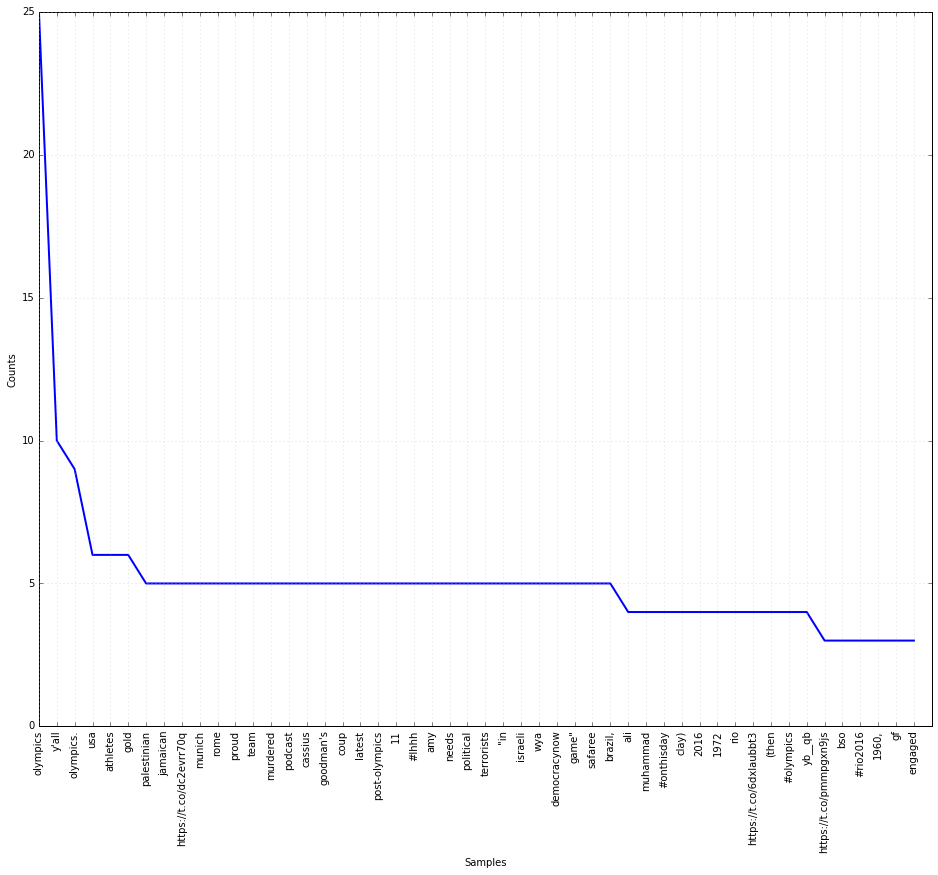

In [77]:
new_tweets_words = [word for word in tweets_words if word not in ignorewords]
    
freq_new = nltk.FreqDist(new_tweets_words)    
freq_new.plot(50)

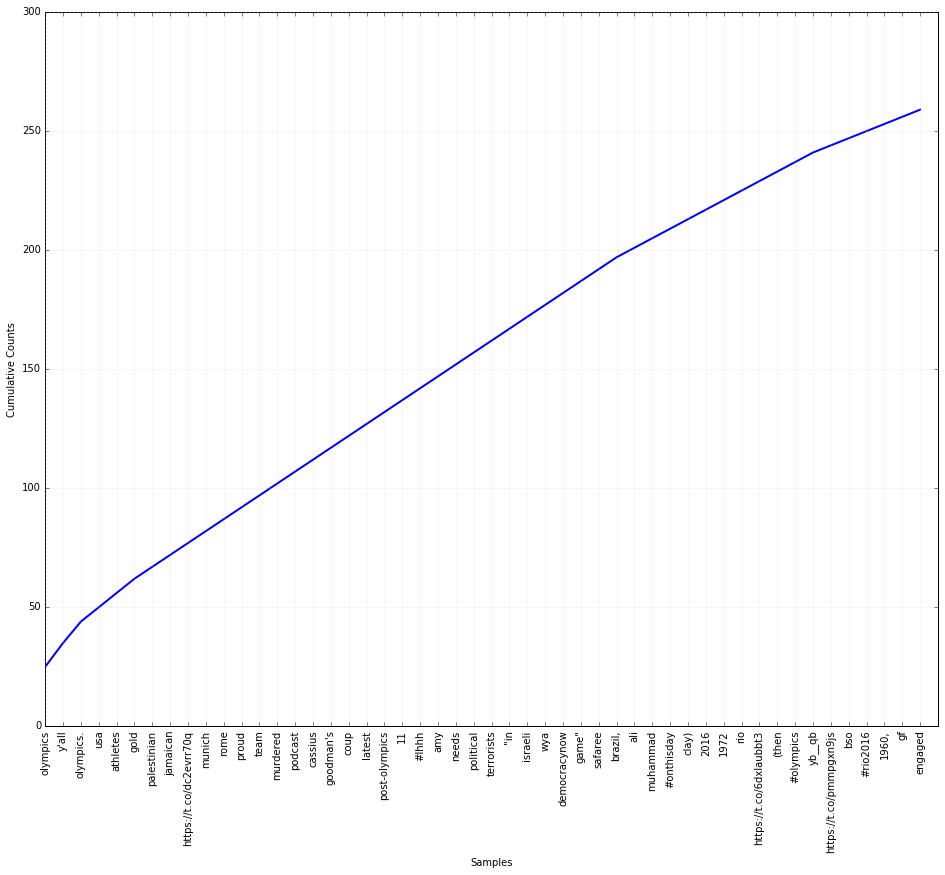

In [78]:
freq_new.plot(50, cumulative = True)

In [79]:
print('10 most frequent words')
print(freq_new.most_common())

10 most frequent words
[('olympics', 25), ("y'all", 10), ('olympics.', 9), ('usa', 6), ('athletes', 6), ('gold', 6), ('palestinian', 5), ('jamaican', 5), ('https://t.co/dc2evrr70q', 5), ('munich', 5), ('rome', 5), ('proud', 5), ('team', 5), ('murdered', 5), ('podcast', 5), ('cassius', 5), ("goodman's", 5), ('coup', 5), ('latest', 5), ('post-olympics', 5), ('11', 5), ('#lhhh', 5), ('amy', 5), ('needs', 5), ('political', 5), ('terrorists', 5), ('"in', 5), ('israeli', 5), ('wya', 5), ('democracynow', 5), ('game"', 5), ('safaree', 5), ('brazil,', 5), ('ali', 4), ('muhammad', 4), ('#onthisday', 4), ('clay)', 4), ('2016', 4), ('1972', 4), ('rio', 4), ('https://t.co/6dxlaubbt3', 4), ('(then', 4), ('#olympics', 4), ('yb__qb', 4), ('https://t.co/pmmpgxn9js', 3), ('bso', 3), ('#rio2016', 3), ('1960,', 3), ('gf', 3), ('engaged', 3), ('hall', 3), ('27', 3), ('remember', 3), ('https://t.co/nuckiryr6k', 3), ('bolt', 3), ('ilnewsflash', 3), ('day', 3), ('gets', 3), ('girls', 3), ('usain', 3), ('(vid)

In [80]:
print('Sorted list of words')
print(sorted(set(new_tweets_words)))

Sorted list of words
['"in', '#boston', '#boxing', '#cdnparalympic', '#competition', '#filltheseats', '#girlpower', '#inmemory', '#israeli', '#lhhh', '#msgwishes', '#munich', '#neverforget', '#olympics', '#onthisday', '#rio2016', "'losing'", "'nejdeh'", '(cbc):#olympics', '(then', '(vid)', '--&gt;', '1', '11', '1960', '1960,', '1972', '2008', '2012', '2016', '2018', '2020', '27', '44', '56', '6.5', 'admitted', 'afp', 'ago', 'ali', 'also', 'amy', 'athlete?\n\nthey', 'athletes', 'ayee..', 'ayf', 'bearer', 'beijing', 'believe', 'best', 'bolt', 'boxingnewsed', 'boycott', 'br_uk', 'brazil,', 'bring', 'bso', 'canada', 'cassius', 'ceremony', 'change_es', 'chapter', 'clay', 'clay)', 'coaches', 'coins', 'colrichardkemp', 'competition', 'congrats', 'coup', 'cufi', 'curse', 'daughter', 'day', 'democracynow', 'determine', 'dog', 'dollars.', "don't", 'easily', 'eating', 'empowering', 'engaged', 'even', 'everyone', 'expert', 'first', 'flag', 'freestyieraps', 'game"', 'gets', 'gf', 'girls', 'gives', 

Counting specific words

In [85]:
print(new_tweets_words.count('athletes'))
print(freq_new['gold']) #same as before
print(freq_new.freq('rio')) #relative to the others

6
6
0.0071301247771836


Eliminating small words or words with specific sizes

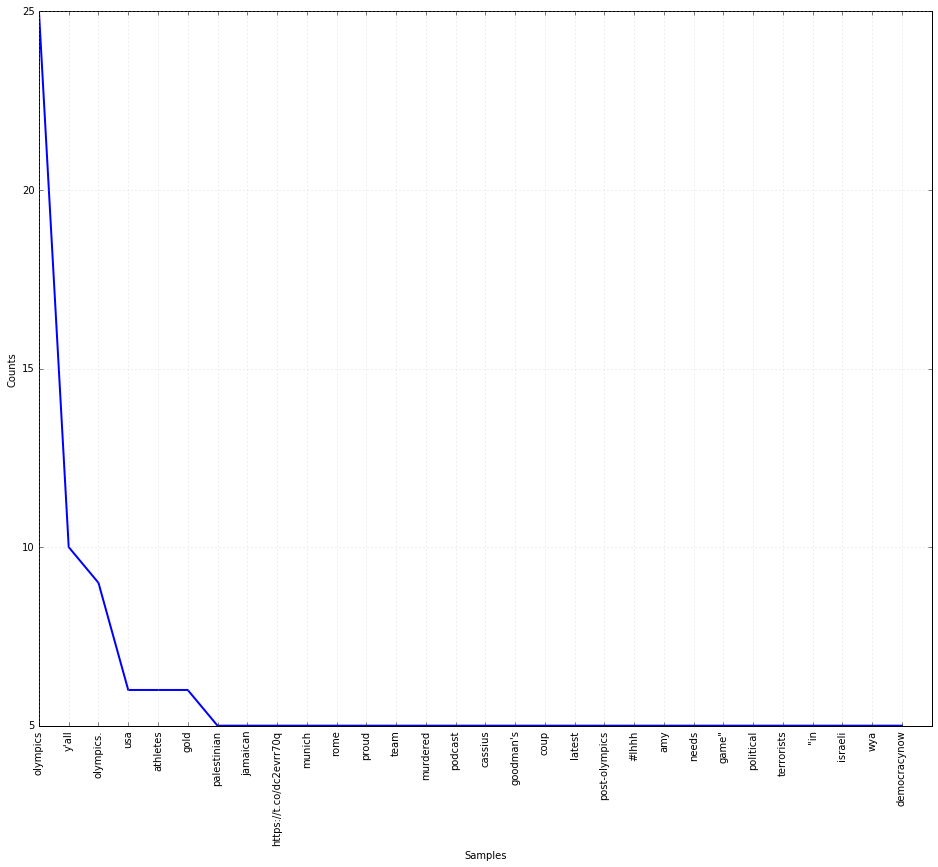

In [86]:
bigger_tweets_words = [word for word in new_tweets_words if len(word) > 2]
#mediumsized_tweets_words = [word for word in new_tweets_words if len(word) > 2 and len(word) < 9]
freq_bigger = nltk.FreqDist(bigger_tweets_words)    
freq_bigger.plot(30)

Citation Analysis

In [87]:
citacoes = [word for word in tweets_words if '@' in word]
#citacoes = [word for word in tweets_words if word.startswith('@')]
freq_citacoes = nltk.FreqDist(citacoes)
freq_citacoes.items()

dict_items([])

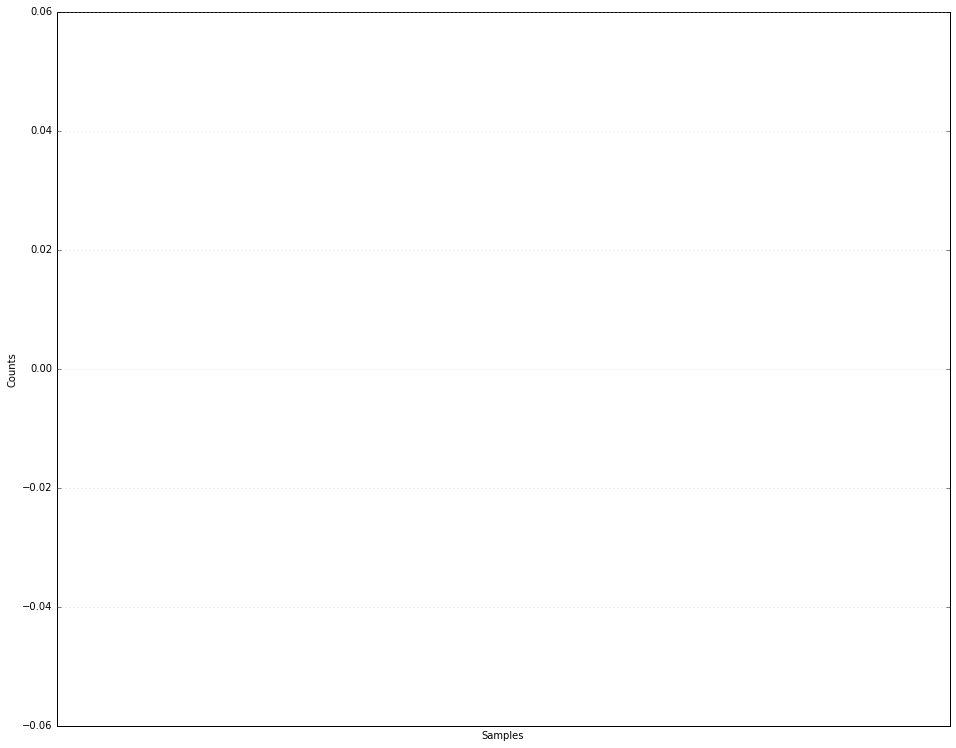

In [89]:
freq_citacoes.plot()

Hashtag Analysis

In [90]:
hashtags = [word for word in tweets_words if word.startswith('#')]
freq_hashtags = nltk.FreqDist(hashtags)
freq_hashtags.items()

dict_items([('#boxing', 1), ('#competition', 1), ('#israeli', 1), ('#boston', 1), ('#neverforget', 1), ('#girlpower', 1), ('#lhhh', 5), ('#rio2016', 3), ('#munich', 1), ('#cdnparalympic', 1), ('#inmemory', 1), ('#filltheseats', 1), ('#onthisday', 4), ('#msgwishes', 1), ('#olympics', 4)])

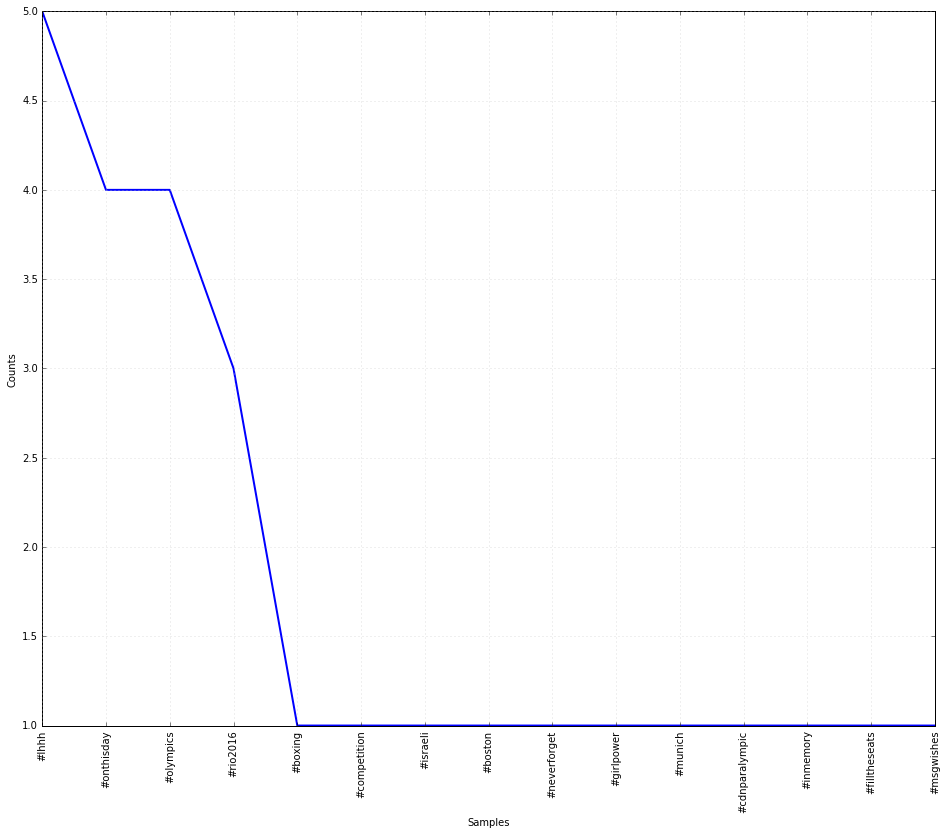

In [91]:
freq_hashtags.plot()

Analysis of Frequent words  
Can be used with any of the previous lists'''

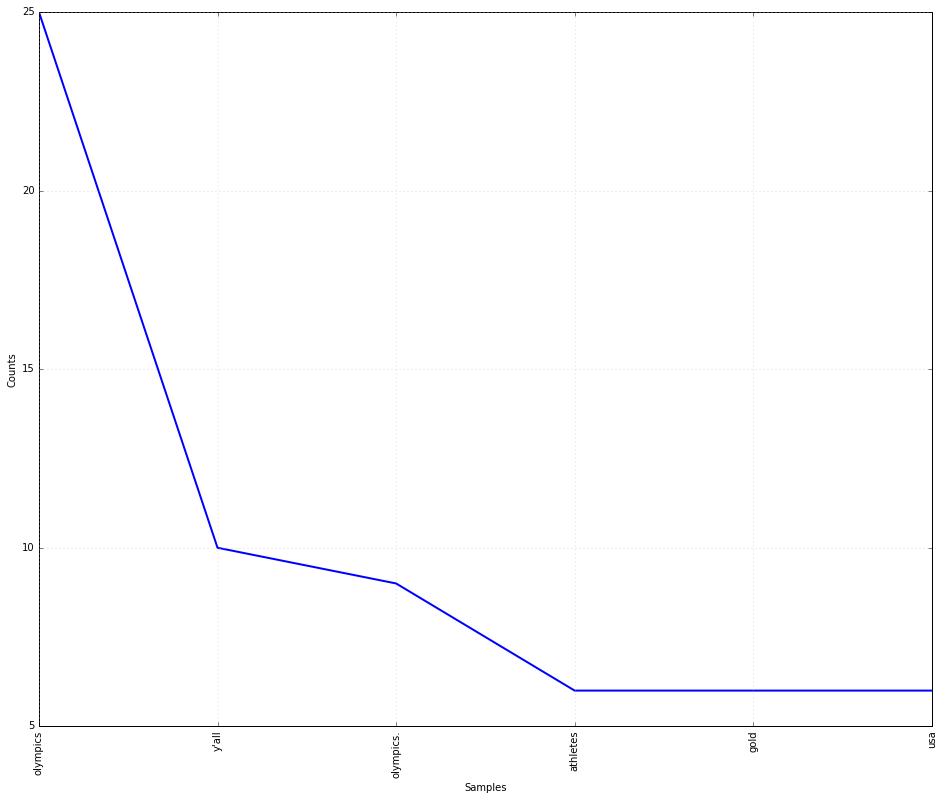

In [92]:
frequent_words = [word.lower() for word in new_tweets_words if tweets_words.count(word) > 5]
freq_dist2 = nltk.FreqDist(frequent_words)
freq_dist2.plot(40)

Words Sizes

In [93]:
freq_size_words = nltk.FreqDist([len(w) for w in new_tweets_words])
freq_size_words.items()

dict_items([(32, 1), (1, 5), (2, 19), (3, 57), (4, 79), (5, 90), (6, 45), (7, 49), (8, 77), (9, 30), (10, 13), (11, 14), (12, 11), (13, 8), (14, 4), (15, 8), (23, 50), (26, 1)])

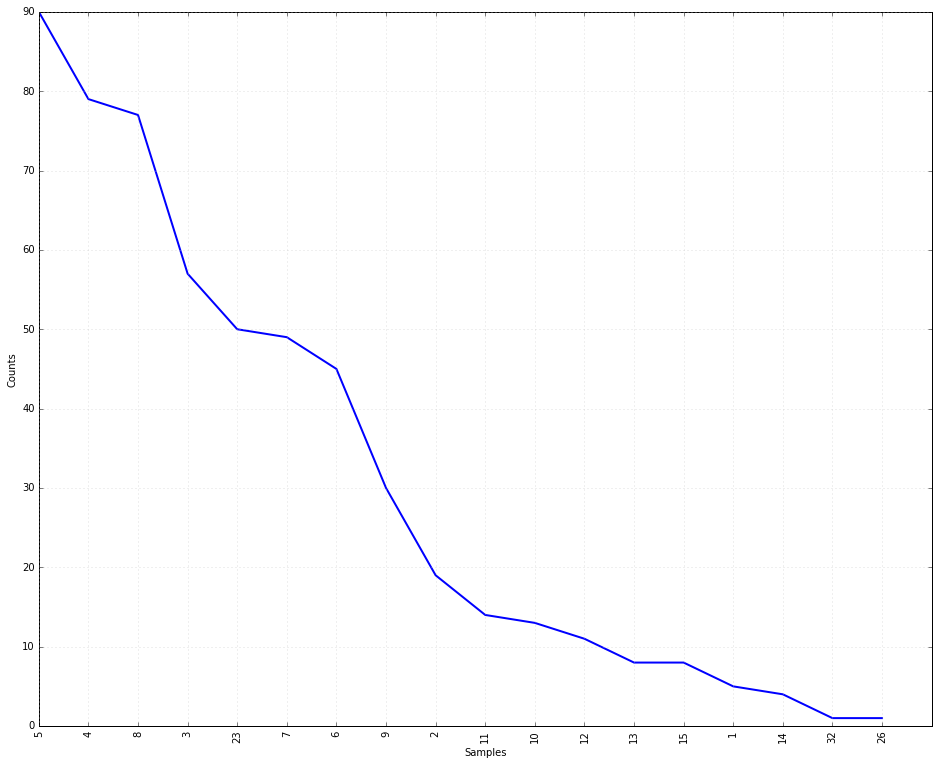

In [94]:
freq_size_words.plot()

Bigrams

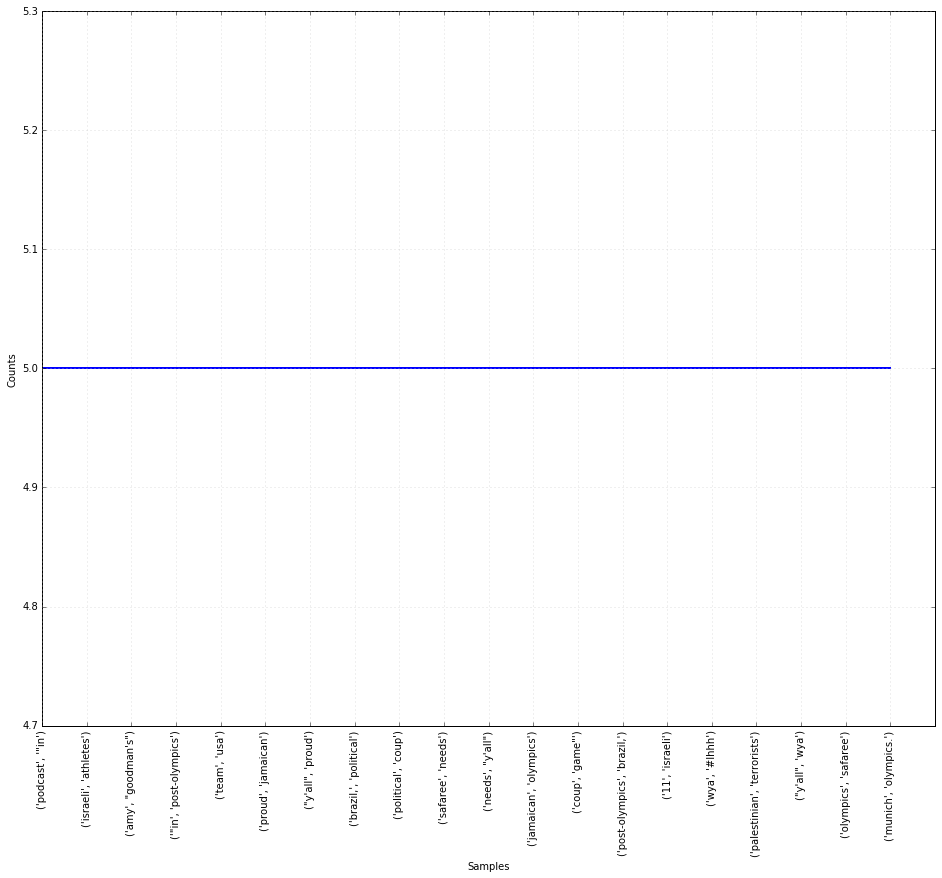

In [95]:
bigramas_tweets = nltk.bigrams(new_tweets_words)
freqbig = nltk.FreqDist(bigramas_tweets)
freqbig.plot(20)

Names (capitalized words)

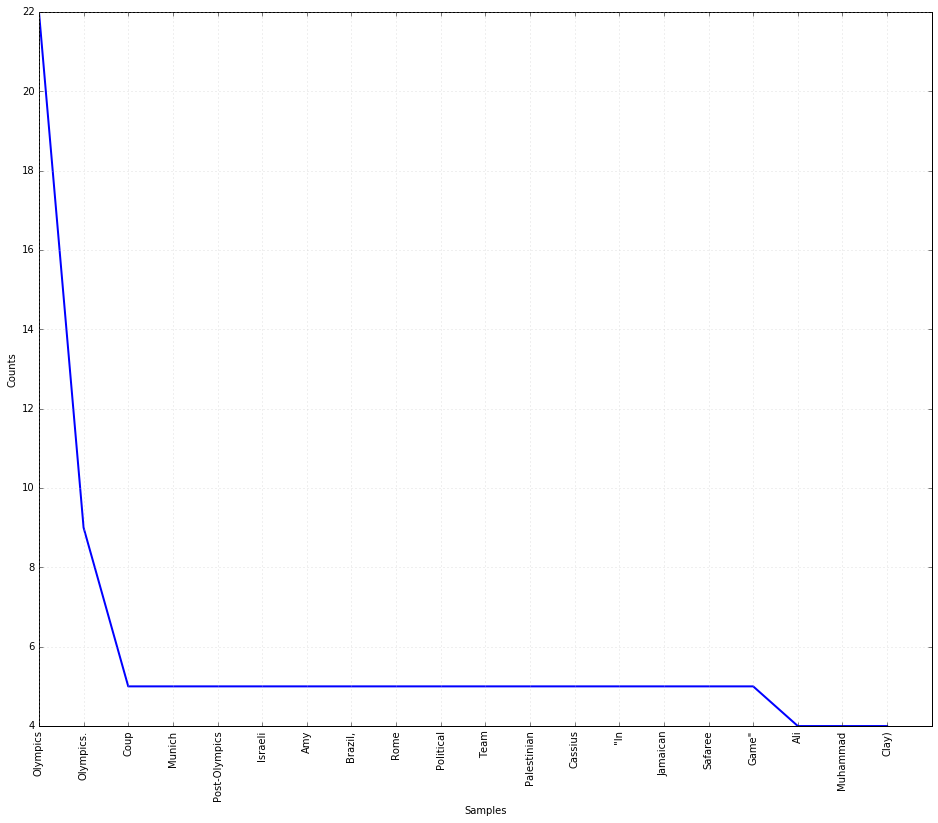

In [96]:
freq_names = nltk.FreqDist(names)
freq_names.plot(20)

#### Sentiment Analysis

In [97]:
badwords =   ['abandoned','abused','accused','addicted','afraid','aggravated',
              'aggressive','alone','angry','anguish','annoyed','anxious','apprehensive',
              'argumentative','artificial','ashamed','assaulted','at a loss','at risk',
              'atrocious','attacked','avoided','awful','awkward','bad','badgered','baffled',
              'banned','barren','beat','beaten down','belittled','berated','betrayed',
              'bitched at','bitter','bizzare','blacklisted','blackmailed','blamed','bleak',
              'blown away','blur','bored','boring','bossed-around','bothered','bothersome',
              'bounded','boxed-in','broken','bruised','brushed-off','bugged','bullied',
              'bummed','bummed out','burdened','burdensome','burned','burned-out',
              'caged in','careless','chaotic','chased','cheated','cheated on','chicken',
              'claustrophobic','clingy','closed','clueless','clumsy','coaxed',
              'codependent','coerced','cold','cold-hearted','combative','commanded',
              'compared','competitive','compulsive','conceited','concerned',
              'condescended to','confined','conflicted','confronted','confused',
              'conned','consumed','contemplative','contempt','contentious','controlled',
              'convicted','cornered','corralled','cowardly','crabby','cramped','cranky',
              'crap','crappy','crazy','creeped out','creepy','critical','criticized',
              'cross','crowded','cruddy','crummy','crushed','cut-down','cut-off','cynical',
              'damaged','damned','dangerous','dark','dazed','dead','deceived','deep',
              'defamed','defeated','defective','defenseless','defensive','defiant',
              'deficient','deflated','degraded','dehumanized','dejected','delicate',
              'deluded','demanding','demeaned','demented','demoralized','demotivated',
              'dependent','depleted','depraved','depressed','deprived','deserted',
              'deserving of pain/punishment','desolate','despair','despairing',
              'desperate','despicable','despised','destroyed','destructive',
              'detached','detest','detestable','detested','devalued','devastated',
              'deviant','devoid','diagnosed','dictated to','different','difficult',
              'directionless','dirty','disabled','disagreeable','disappointed',
              'disappointing','disapproved of','disbelieved','discardable','discarded',
              'disconnected','discontent','discouraged','discriminated','disdain',
              'disdainful','disempowered','disenchanted','disgraced','disgruntled',
              'disgust','disgusted','disheartened','dishonest','dishonorable',
              'disillusioned','dislike','disliked','dismal','dismayed','disorganized',
              'disoriented','disowned','displeased','disposable','disregarded',
              'disrespected','dissatisfied','distant','distracted','distraught',
              'distressed','disturbed','dizzy','dominated','doomed','double-crossed',
              'doubted','doubtful','down','down and out','down in the dumps',
              'downhearted','downtrodden','drained','dramatic','dread','dreadful',
              'dreary','dropped','drunk','dry','dumb','dumped','dumped on','duped',
              'edgy','egocentric','egotistic','egotistical','elusive','emancipated',
              'emasculated','embarrassed','emotional','emotionless','emotionally bankrupt',
              'empty','encumbered','endangered','enraged','enslaved','entangled','evaded',
              'evasive','evicted','excessive','excluded','exhausted','exploited','exposed',
              'fail','failful','fake','false','fear','fearful','fed up','flawed','forced',
              'forgetful','forgettable','forgotten','fragile','freaked out','frightened',
              'frigid','frustrated','furious','gloomy','glum','gothic','grey','grief','grim',
              'gross','grossed-out','grotesque','grouchy','grounded','grumpy','guilt-tripped',
              'guilty','harassed','hard','hard-hearted','harmed','hassled','hate','hateful',
              'hatred','haunted','heartbroken','heartless','heavy-hearted','helpless',
              'hesitant','hideous','hindered','hopeless','horrible','horrified','horror',
              'hostile','hot-tempered','humiliated','hung up','hung over','hurried','hurt',
              'hysterical','idiot','idiotic','ignorant','ignored','ill','ill-tempered',
              'imbalanced','imposed-upon','impotent','imprisoned','impulsive','in the dumps',
              'in the way','inactive','inadequate','incapable','incommunicative','incompetent',
              'incompatible','incomplete','incorrect','indecisive','indifferent',
              'indoctrinated','inebriated','ineffective','inefficient','inferior',
              'infuriated','inhibited','inhumane','injured','injusticed','insane',
              'insecure','insignificant','insincere','insufficient','insulted',
              'intense','interrogated','interrupted','intimidated','intoxicated',
              'invalidated','invisible','irrational','irritable','irritated',
              'isolated','jaded','jealous','jerked around','joyless','judged',
              'kept apart','kept away','kept in','kept out','kept quiet','labeled',
              'laughable','laughed at','lazy','leaned on','lectured to','left out',
              'let down','lied about','lied to','limited','little','lonely','lonesome',
              'longing','lost','lousy','loveless','low','mad','made fun of','man handled',
              'manipulated','masochistic','messed with','messed up','messy','miffed',
              'miserable','misled','mistaken','mistreated','mistrusted','misunderstood',
              'mixed-up','mocked','molested','moody','nagged','needy','negative',
              'nervous','neurotic','nonconforming','numb','nuts','nutty','objectified',
              'obligated','obsessed','obsessive','obstructed','odd','offended',
              'on display','opposed','oppressed','out of place','out of touch',
              'over-controlled','over-protected','overwhelmed','pain','panic','paranoid',
              'passive','pathetic','pessimistic','petrified','phony','picked on','pissed',
              'pissed off','plain','played with','pooped','poor','powerless','pre-judged',
              'preached to','preoccupied','predjudiced','pressured','prosecuted',
              'provoked','psychopathic','psychotic','pulled apart','pulled back',
              'punished','pushed','pushed away','put down','puzzled','quarrelsome',
              'queer','questioned','quiet','rage','raped','rattled','regret','rejected',
              'resented','resentful','responsible','retarded','revengeful','ridiculed',
              'ridiculous','robbed','rotten','sad','sadistic','sarcastic','scared',
              'scarred','screwed','screwed over','screwed up','self-centered','self-conscious',
              'self-destructive','self-hatred','selfish','sensitive','shouted at','shy',
              'singled-out','slow','small','smothered','snapped at','spiteful','stereotyped',
              'strange','stressed','stretched','stuck','stupid','submissive','suffering',
              'suffocated','suicidal','superficial','suppressed','suspicious','worse','worst'
              ,'bankrupcy','jobs','shit','socialism','#sob']

In [98]:
goodwords =  ['Abundant','Accomplished','Achieving','Active','Admirable','Adorable',
              'Adventurous','Admired','Affluent','Agreeable','Alert','Aligned','Alive',
              'Amazing','Appealing','Appreciate','Artistic','Astounding','Astute',
              'Attentive','Attractive','Auspicious','Authentic','Awake','Aware','Awesome',
              'Beaming','Beautiful','Better','Best','Blessed','Bliss','Bold','Bright','Brilliant',
              'Brisk','Buoyant','Calm','Capable','Centered','Certain','Charming',
              'Cheerful','Clear','Clever','Competent','Complete','Confident','Connected',
              'Conscious','Considerate','Convenient','Courageous','Creative','Daring',
              'Dazzling','Delicious','Delightful','Desirable','Determined','Diligent',
              'Discerning','Discover','Dynamic','Eager','Easy','Efficient','Effortless',
              'Elegant','Eloquent','Energetic','Endless','Enhancing','Engaging','Enormous'
              ,'Enterprising','Enthusiastic','Enticing','Excellent','Exceptional','Exciting'
              ,'Experienced','Exquisite','Fabulous','Fair','Far-Sighted','Fascinating',
              'Fine','Flattering','Flourishing','Fortunate','Free','Friendly','Fulfilled',
              'Fun','Generous','Genuine','Gifted','Glorious','Glowing','Good','Good-Looking',
              'Gorgeous','Graceful','Gracious','Grand','Great','Handsome','Happy','Hardy',
              'Harmonious','Healed','Healthy','Helpful','Honest','Humorous','Ideal',
              'Imaginative','Impressive','Industrious','Ingenious','Innovative','Inspired',
              'Intelligent','Interested','Interesting','Intuitive','Inventive','Invincible',
              'Inviting','Irresistible','Joyous','Judicious','Keen','Kind','Knowing','Leader',
              'Limitless','Lively','Loving','Lucky','Luminous','Magical','Magnificent',
              'Marvellous','Masterful','Mighty','Miraculous','Motivated','Natural','Neat',
              'Nice','Nurturing','Noble','Optimistic','Outstanding','Passionate','Peaceful',
              'Perfect','Persevering','Persistent','Playful','Pleasing','Plentiful','Positive',
              'Powerful','Precious','Prepared','Productive','Profound','Prompt','Prosperous',
              'Proud','Qualified','Quick','Radiant','Reasonable','Refined','Refreshing',
              'Relaxing','Reliable','Remarkable','Resolute','Resourceful','Respected',
              'Rewarding','Robust','Safe','Satisfied','Secure','Seductive','Self-Reliant',
              'Sensational','Sensible','Sensitive','Serene','Sharing','Skilful','Smart',
              'Smashing','Smooth','Sparkling','Spiritual','Splendid','Strong','Stunning',
              'Successful','Superb','Swift','Talented','Tenacious','Terrific','Thankful',
              'Thrilling','Thriving','Timely','Trusting','Truthful','Ultimate','Unique',
              'Valiant','Valuable','Versatile','Vibrant','Victorious','Vigorous','Vivacious',
              'Vivid','Warm','Wealthy','Well','Whole','Wise','Wonderful','Worthy','Young',
              'Youthful','Zeal','Zest']

In [99]:
def percentage(count, total):
    return 100 * count / float(total)

In [100]:
def sentiment_analysis(texto, goodwords, badwords):
    '''
    Not a sophisticated one, but the main idea is present.
    Please read: http://alias-i.com/lingpipe/demos/tutorial/sentiment/read-me.html
    '''
    goodness = 0
    badness = 0    
    for word in goodwords:
        goodness += percentage(texto.count(word.lower()), len(texto))
    for word in badwords:
        badness += percentage(texto.count(word.lower()), len(texto))
    if badness:
        ratio = goodness/float(badness)
    print(u'Grau de negatividade: {}'.format(badness))
    print(u'Grau de positividade: {}'.format(goodness))
    if badness:
        print(u'Razão: {}'.format(ratio))
    return goodness, badness

In [101]:
sentiment_analysis(tweets_words, goodwords, badwords);

Grau de negatividade: 0.0
Grau de positividade: 1.2610340479192939


#### Geographic Analysis

https://pypi.python.org/pypi/basemap/1.0.7  
http://matplotlib.org/basemap/  
http://matplotlib.org/basemap/users/installing.html  
http://nbviewer.ipython.org/github/ehmatthes/intro_programming/blob/master/notebooks/visualization_earthquakes.ipynb  

In [108]:
#http://matplotlib.org/basemap/api/basemap_api.html
from mpl_toolkits.basemap import Basemap

ImportError: libgeos-3.3.3.so: cannot open shared object file: No such file or directory

In [111]:
msgpublicas = api.GetStreamSample()
geo_points = 0
lats, lons = [], []
users = []
while geo_points < 20:
    tweet = next(msgpublicas)
    if 'coordinates' in tweet.keys() and tweet['coordinates'] != None:
        coords = tweet['coordinates']['coordinates']
        user = tweet['user']['id']
        print(u'Usuário {} nas coordenadas {}'.format(user, [coords[1],coords[0]]))
        lons.append(float(coords[0]))
        lats.append(float(coords[1]))
        users.append(user)
        geo_points +=1

Usuário 16847725 nas coordenadas [30.2672, -97.7639]
Usuário 303614993 nas coordenadas [-18.9167, -48.3]
Usuário 177346974 nas coordenadas [-1.29336803, -47.9249678]
Usuário 439002007 nas coordenadas [-6.24084, 106.90083]
Usuário 323769612 nas coordenadas [40.2076284, 29.07318326]
Usuário 23233058 nas coordenadas [41.8781136, -87.6297982]
Usuário 476738747 nas coordenadas [3.04373102, 101.51751032]
Usuário 3055641761 nas coordenadas [41.15228312, -8.67833963]
Usuário 2959758200 nas coordenadas [3.2565552, 101.72712783]
Usuário 249062870 nas coordenadas [-6.22926, 106.85372]
Usuário 1562165282 nas coordenadas [16.48381107, 102.81861829]
Usuário 1649438594 nas coordenadas [-0.9564213, 100.3604686]
Usuário 28447324 nas coordenadas [37.7719074, -87.1111676]
Usuário 761306248390270977 nas coordenadas [44.97997, -93.26384]
Usuário 100008156 nas coordenadas [38.2097967, -84.5588311]
Usuário 718718395 nas coordenadas [38.75524614, 30.55513193]
Usuário 2165365458 nas coordenadas [51.52507387, -

In [112]:
map = Basemap(projection='robin', resolution = 'l', area_thresh = 1000.0, lat_0=0, lon_0=0)

map.drawcoastlines()
map.drawcountries()
map.fillcontinents(color = '#FFFFCC') #http://www.w3schools.com/tags/ref_colorpicker.asp
map.drawmapboundary()
map.drawmeridians(np.arange(0, 360, 30))
map.drawparallels(np.arange(-90, 90, 30))

x,y = map(lons, lats)
map.plot(x, y, 'ro', markersize=6)
plt.show()

NameError: name 'Basemap' is not defined

In [ ]:
map = Basemap(projection='merc', lat_0 = -22, lon_0 = -56.5,resolution = 'h', area_thresh = 0.1, 
              llcrnrlon=-83.0, llcrnrlat=-57.0, urcrnrlon=-30.0, urcrnrlat=13.0)
 
map.drawcoastlines()
map.drawcountries()
map.fillcontinents(color = 'coral')
map.drawmapboundary()

x,y = map(lons, lats)
map.plot(x, y, 'bo', markersize=10)

plt.show()

Zoom em uma coordenada:

In [113]:
def gmap(lat,lon,zoom=10):
    # Google Maps URL template for an iframe
    google_maps_url = "http://maps.google.com/maps?q={0}+{1}&ie=UTF8&t=h&z={2}&{0},{1}&output=embed".format(lat,lon,zoom)
    display(IFrame(google_maps_url, '800px', '600px'))

In [114]:
gmap(lats[0],lons[0],4)

#### Graphs

http://networkx.lanl.gov/  

In [116]:
def get_rt_origins(tweet):
    ''' Regex adapted from 
    http://stackoverflow.com/questions/655903/python-regular-expression-for-retweets'''
    rt_patterns = re.compile(r"(RT|via)((?:\b\W*@\w+)+)", re.IGNORECASE)
    rt_origins = []
    try:
        rt_origins += [mention.strip() for mention in rt_patterns.findall(tweet)[0][1].split()]
    except IndexError as e:
        pass
    return [rto.strip("@") for rto in rt_origins]

In [117]:
def create_graph_retweets(tweets):
    g = nx.DiGraph()
    for tweet in tweets:
        rt_origins = get_rt_origins(tweet.text)
        if not rt_origins:
            continue
        for rt_origin in rt_origins:
            g.add_edge(rt_origin, tweet.user.screen_name, {'tweet_id': tweet.id})
    return g

In [118]:
g_rt = create_graph_retweets(tweets)
print("Number of nodes is: {}\n".format(g_rt.number_of_nodes()))
print("Number of edges is: {}\n".format(g_rt.number_of_edges()))

Number of nodes is: 52

Number of edges is: 32



In [119]:
import operator
sorted_dic = sorted(g_rt.degree().items(), key=operator.itemgetter(1), reverse=True)
sorted_dic

[('YB__QB', 4),
 ('democracynow', 4),
 ('ILNewsFlash', 3),
 ('BSO', 3),
 ('Laceupboxing', 2),
 ('LegendaryRoasts', 2),
 ('armisbbe', 1),
 ('Gurmeetramrahim', 1),
 ('andrujo189', 1),
 ('COLRICHARDKEMP', 1),
 ('BoxingNewsED', 1),
 ('firstlastsecond', 1),
 ('topiclyolympics', 1),
 ('BrunoCornejo95', 1),
 ('salkken', 1),
 ('FrostyRoot', 1),
 ('JAMESGRANTPR', 1),
 ('London_Lady', 1),
 ('HistoricalPics', 1),
 ('VinePhilly', 1),
 ('politivons', 1),
 ('Cam_Breezy_1998', 1),
 ('__TierraMariee', 1),
 ('LissaDenise', 1),
 ('IDFSpokesperson', 1),
 ('ReedRollings', 1),
 ('JWren87', 1),
 ('3rdstreetjazz', 1),
 ('YWCAUSA', 1),
 ('GlumGeorgeLucas', 1),
 ('TylerRoehr', 1),
 ('_therealfola', 1),
 ('itsdougthepug', 1),
 ('br_uk', 1),
 ('Reganaught', 1),
 ('DomoFamSauce', 1),
 ('authorharpmill', 1),
 ('Master_Shae', 1),
 ('theananyasingh1', 1),
 ('FreestyIeRaps', 1),
 ('CUFI', 1),
 ('EthanConstant', 1),
 ('shantespice', 1),
 ('varunvd', 1),
 ('Jalen_Blalock', 1),
 ('makarov__', 1),
 ('OscarArrascue', 1),


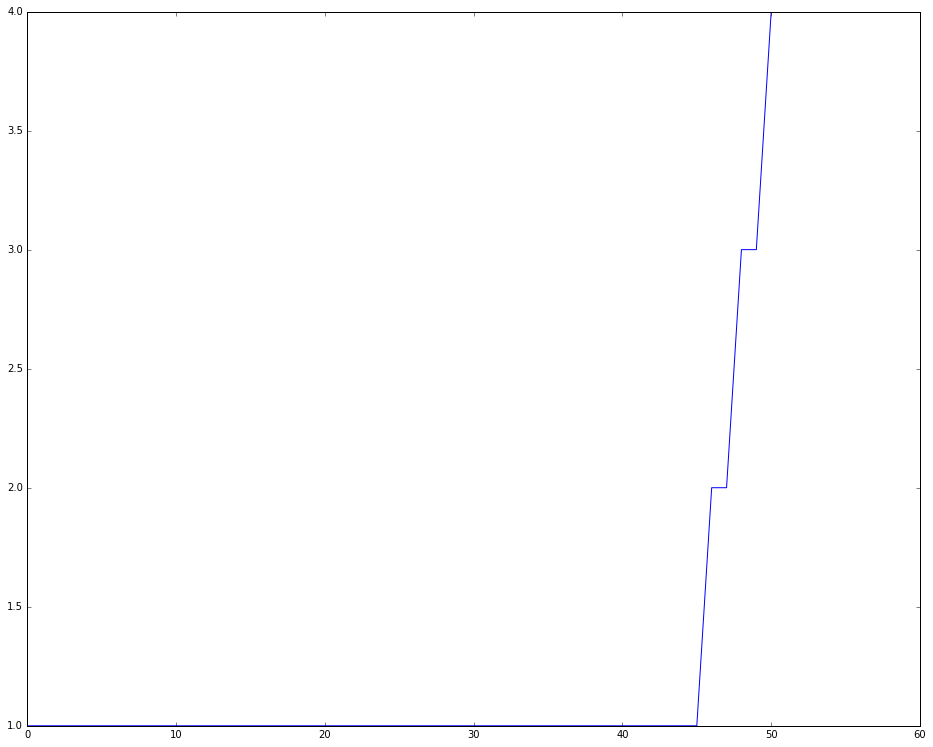

In [120]:
dic = nx.degree(g_rt)
plt.plot(sorted(dic.values()))

In [125]:
def save_dotfile(g):
    try:
        nx.drawing.write_dot(g, pathdotfile)
        print >> sys.stderr, 'Graph exported for file: {}'.format(pathdotfile)
    except (ImportError, UnicodeEncodeError, AttributeError): 
        # Este bloco serve para usuarios de windows, que certamente terao problemas
        # com o metodo nx.drawing.write_dot. Tambem serve para os casos em que temos
        # problemas com o unicode
        dot = [u'"{}" -> "{}" [tweet_id={}]'.format(n1, n2, g[n1][n2]['tweet_id']) for (n1, n2) in g.edges()]
        f = codecs.open(pathdotfile, 'w', encoding='utf-8')
        f.write('''strict digraph {{}}'''.format(';\n'.join(dot), ))
        f.close()
        print(sys.stderr, 'Graph exported for file: {}'.format(pathdotfile))
        return f.name

In [126]:
save_dotfile(g_rt)

<ipykernel.iostream.OutStream object at 0x7f3e9d68b358> Graph exported for file: ../outputs/graph_retweet.dot


'../outputs/graph_retweet.dot'

Saving a dotfile

Obs: To generate a png graph from the dotfile, type in the Unix Prompt: 
'circo -Tpng -Gcharset=latin1 -Ograph_retweet graph_retweet.dot'

In [128]:
#Chamando um programa externo ao Ipython com o operador !
!dot -Tpng ../outputs/graph_retweet.dot -o ../outputs/graph_retweet.png
Image(pathpngfile)

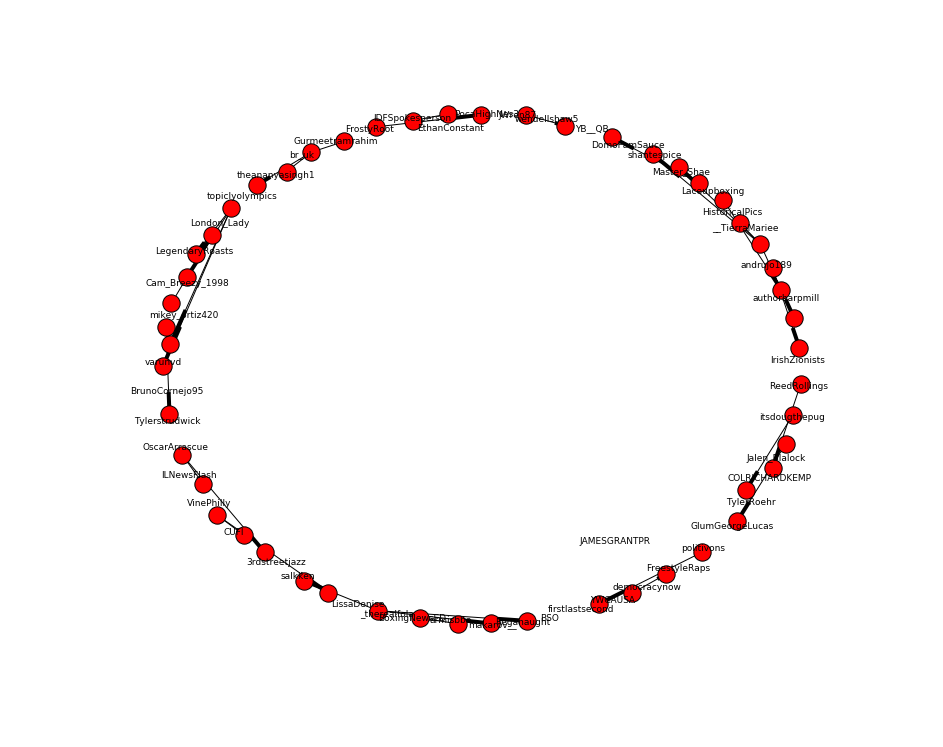

In [129]:
nx.draw_networkx_labels(g_rt,pos=nx.spring_layout(g_rt),font_size=9)
nx.draw(g_rt)
#nx.draw_random(g_rt)
#nx.draw_circular(g_rt)
#nx.draw_spectral(g_rt)

Saving a HTML file that uses javascript for visualizing the graph (needs a template)

In [135]:
def save_protovis_file(g):
    '''A visualization alternative is "protovis" javascript
    It uses the files "template_protoviz.html and "protovis-r3.2.js"
    '''
    nodes = g.nodes()
    indexed_nodes = {}
    idx = 0
    for n in nodes:
        indexed_nodes.update([(n, idx,)])
        idx += 1
    links = []
    for n1, n2 in g.edges():
        links.append({'source': indexed_nodes[n2],'target': indexed_nodes[n1]})
    json_data = json.dumps({"nodes" : [{"nodeName" : n} for n in nodes], "links" : links}, indent=4)
    html = open(pathtemplate).read().format(json_data,)
    f = open(pathprotofile, 'w')
    f.write(html)
    f.close()
    print(sys.stderr, 'Graph exported for file: {}'.format(pathprotofile))
    return f.name, html

In [136]:
s = save_protovis_file(g_rt)

<ipykernel.iostream.OutStream object at 0x7f3e9d68b358> Graph exported for file: ../outputs/graph_retweet.html


In [139]:
#!chromium ../outputs/graph_retweet.html
# http://docs.python.org/library/webbrowser.html 
webbrowser.open(pathprotofile)

True